In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.stats import norm, kstest, t
from statsmodels.api import distributions
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, het_goldfeldquandt, acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf

       STATION        NAME  LATITUDE  LONGITUDE  ELEVATION       DATE  PRCP  \
0  PLM00012375  OKECIE, PL    52.166     20.967      110.3 1993-01-01   0.0   
1  PLM00012375  OKECIE, PL    52.166     20.967      110.3 1993-01-02   NaN   
2  PLM00012375  OKECIE, PL    52.166     20.967      110.3 1993-01-03   0.0   
3  PLM00012375  OKECIE, PL    52.166     20.967      110.3 1993-01-04   0.0   
4  PLM00012375  OKECIE, PL    52.166     20.967      110.3 1993-01-05   0.0   

   SNWD  TAVG  TMAX  TMIN  
0  10.0  -8.3   NaN   NaN  
1  10.0 -14.9   NaN   NaN  
2  10.0 -13.6  -9.7   NaN  
3  10.0 -10.5  -6.5 -13.3  
4  10.0 -12.0  -8.9 -14.1  


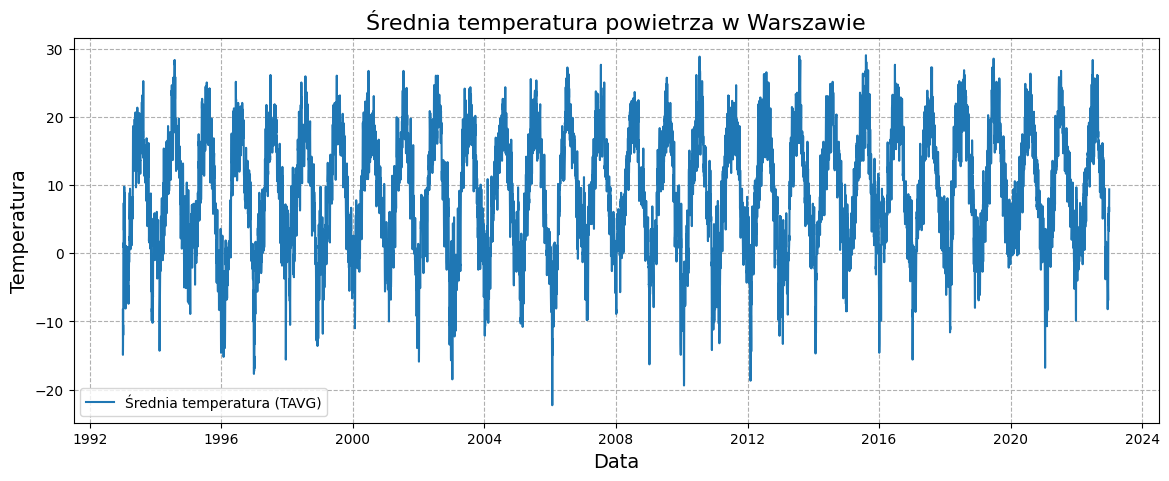

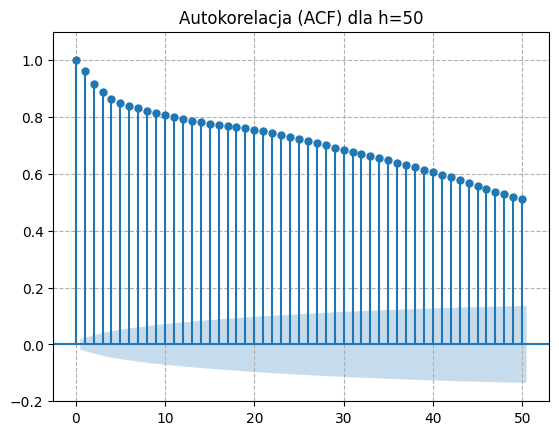

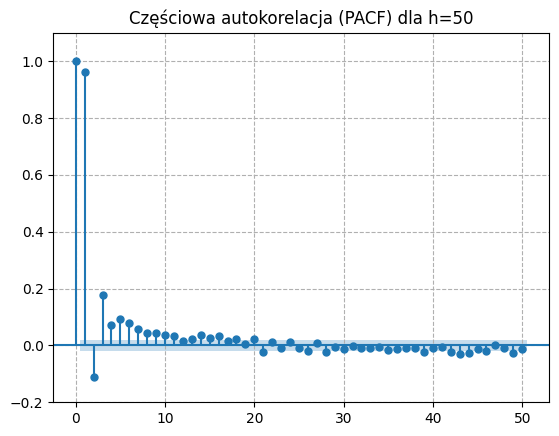

In [3]:
file ="warsaw.csv"
all_data = pd.read_csv(file)
all_data['DATE'] = pd.to_datetime(all_data['DATE'])

start_date = "1993-01-01"
end_date = "2022-12-31"
data = all_data[(all_data['DATE'] >= start_date) & (all_data['DATE'] <= end_date)]

print(data.head())
temp = data['TAVG']


plt.figure(figsize=(14, 5))  
plt.plot(data['DATE'], temp, label='Średnia temperatura (TAVG)')
plt.title('Średnia temperatura powietrza w Warszawie', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura', fontsize=14)
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

h = 50
plot_acf(temp, lags=h, adjusted=True, title=f"Autokorelacja (ACF) dla h={h}", ax=plt.gca()) 
plt.grid(True, linestyle="--")
plt.ylim(-0.2, 1.1)
plt.show()

plot_pacf(temp, lags=h, method='ywm', title=f"Częściowa autokorelacja (PACF) dla h={h}", ax=plt.gca())
plt.grid(True, linestyle="--")
plt.ylim(-0.2, 1.1)
plt.show()

In [ ]:
min_temp = -20  
max_temp = 30  

out_of_range = data[(data['TAVG'] < min_temp) | (data['TAVG'] > max_temp)]
print(f"Znaleziono {len(out_of_range)} wartości spoza zakładanego przedziału:")
print(out_of_range)

Znaleziono 3 wartości spoza zakładanego przedziału:
          STATION        NAME  LATITUDE  LONGITUDE  ELEVATION       DATE  \
4768  PLM00012375  OKECIE, PL    52.166     20.967      110.3 2006-01-22   
4769  PLM00012375  OKECIE, PL    52.166     20.967      110.3 2006-01-23   
4770  PLM00012375  OKECIE, PL    52.166     20.967      110.3 2006-01-24   

      PRCP   SNWD  TAVG  TMAX  TMIN  
4768   2.3  259.0 -20.8 -15.8 -22.7  
4769   0.0  259.0 -22.3 -16.7 -26.8  
4770   NaN  259.0 -20.4 -15.0 -27.1  


In [ ]:
print("brakujące dane TAVG: ", data['TAVG'].isnull().sum())

full_date_range = pd.date_range(start='1993-01-01', end='2022-12-31', freq='D')
missing_dates = full_date_range.difference(data['DATE'])
print(f"Brakujące daty: {missing_dates}")

brakujące dane TAVG:  0
Brakujące daty: DatetimeIndex(['1999-01-10', '2021-02-11', '2021-02-12'], dtype='datetime64[ns]', freq=None)


In [ ]:
temp = data['TAVG']

def stl_decomposition(Xt):
    stl = STL(Xt, period=365, robust=True) 
    result = stl.fit()
    return result

stl_result = stl_decomposition(temp)

trend = stl_result.trend
seasonal = stl_result.seasonal
clean = stl_result.resid

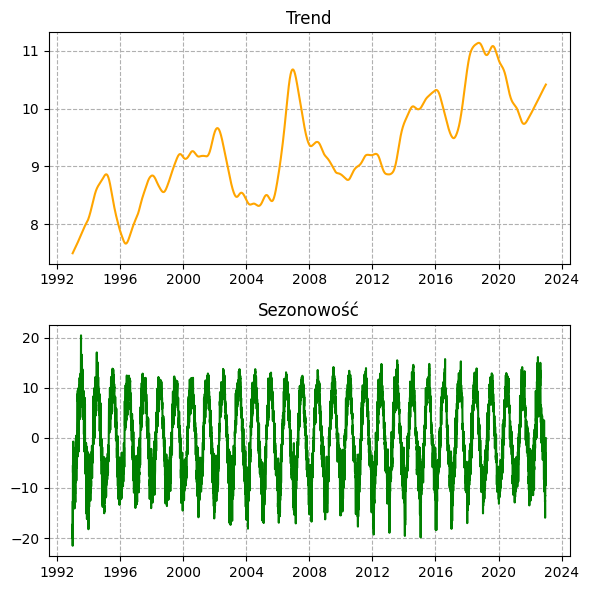

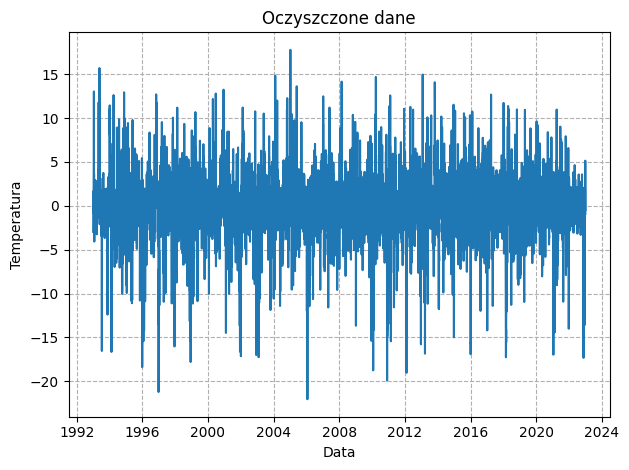

In [7]:
plt.figure(figsize=(6, 6))

plt.subplot(2, 1, 1)
plt.plot(data['DATE'], trend, color='orange')
plt.grid(linestyle="--")
plt.title("Trend")

plt.subplot(2, 1, 2)
plt.plot(data['DATE'], seasonal, color='green')
plt.grid(linestyle="--")
plt.title("Sezonowość")

plt.tight_layout()
plt.show()

plt.plot(data['DATE'], clean)
plt.grid(linestyle="--")
plt.xlabel('Data')
plt.ylabel('Temperatura')
plt.title("Oczyszczone dane")

plt.tight_layout()
plt.show()

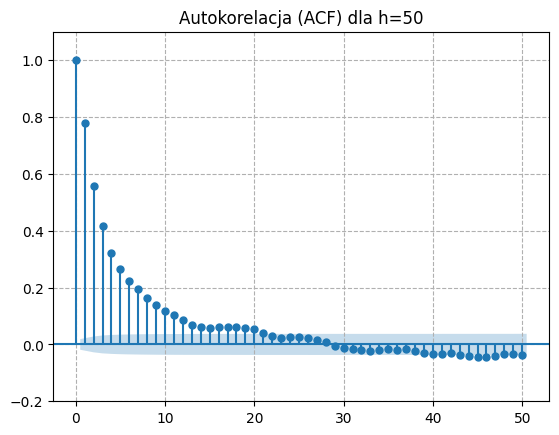

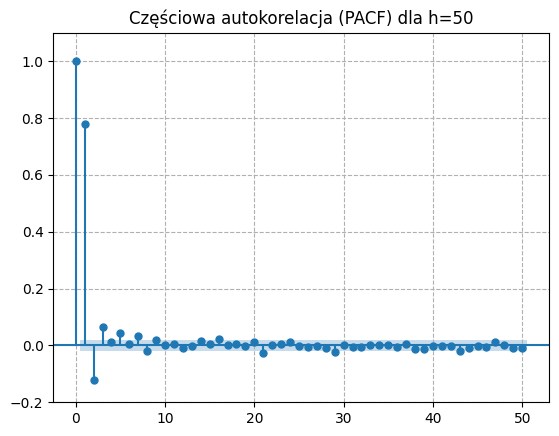

In [8]:
plot_acf(clean, lags=h, adjusted=True, title=f"Autokorelacja (ACF) dla h={h}", ax=plt.gca()) 
plt.grid(True, linestyle="--")
plt.ylim(-0.2, 1.1)
plt.show()

plot_pacf(clean, lags=h, method='ywm', title=f"Częściowa autokorelacja (PACF) dla h={h}", ax=plt.gca())
plt.grid(True, linestyle="--")
plt.ylim(-0.2, 1.1)
plt.show()

## CZĘŚĆ TRZECIA

In [9]:
df = pd.DataFrame()
ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 3
max_q = 3

for p in range(0, max_p):
    for q in range(0, max_q):
        model = ARIMA(clean, order=(p, 0, q))
        model_fit = model.fit()
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [10]:
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
8,2,2,48238.421372,48282.230132,48253.183428
5,1,2,48259.409319,48295.916619,48271.711033
7,2,1,48262.195128,48298.702428,48274.496842
4,1,1,48276.842119,48306.047959,48286.683490
6,2,0,48302.039887,48331.245727,48311.881258


In [11]:
df.sort_values(by='BIC').head()

,p,q,AIC,BIC,HQIC
8,2,2,48238.421372,48282.230132,48253.183428
5,1,2,48259.409319,48295.916619,48271.711033
7,2,1,48262.195128,48298.702428,48274.496842
4,1,1,48276.842119,48306.047959,48286.683490
6,2,0,48302.039887,48331.245727,48311.881258


In [12]:
df.sort_values(by='HQIC').head()

,p,q,AIC,BIC,HQIC
8,2,2,48238.421372,48282.230132,48253.183428
5,1,2,48259.409319,48295.916619,48271.711033
7,2,1,48262.195128,48298.702428,48274.496842
4,1,1,48276.842119,48306.047959,48286.683490
6,2,0,48302.039887,48331.245727,48311.881258


In [13]:
phi_1, phi_2 = model_fit.params.iloc[1], model_fit.params.iloc[2]  
theta_1, theta_2 = model_fit.params.iloc[3], model_fit.params.iloc[4]  

print(f"phi_1: {phi_1}, phi_2: {phi_2}, theta_1: {theta_1}, theta_2: {theta_2}")

phi_1: 1.4501677401630095, phi_2: -0.5007660114058585, theta_1: -0.572148009309806, theta_2: -0.1821090480848897


In [14]:
model = ARIMA(temp, order=(2, 0, 2))  # ARMA(2, 2)
model_fit = model.fit()

residuals = model_fit.resid

<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\T'
<>:8: SyntaxWarning: invalid escape sequence '\T'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\T'
<>:8: SyntaxWarning: invalid escape sequence '\T'
C:\Users\user\AppData\Local\Temp\ipykernel_7536\1247490612.py:8: SyntaxWarning: invalid escape sequence '\p'
  plt.xticks(range(4), ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$'])
C:\Users\user\AppData\Local\Temp\ipykernel_7536\1247490612.py:8: SyntaxWarning: invalid escape sequence '\p'
  plt.xticks(range(4), ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$'])
C:\Users\user\AppData\Local\Temp\ipykernel_7536\1247490612.py:8: SyntaxWarning: invalid escape sequence '\T'
  plt.xticks(range(4), ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$'])
C:\Users\user\AppData\Local\Temp\ipykernel

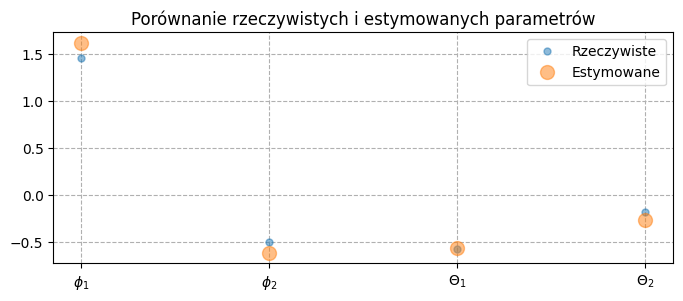

In [15]:
true_params = [phi_1, phi_2, theta_1, theta_2] 
predicted_params = model_fit.params[1:-1] 

plt.figure(figsize=(8, 3))
plt.plot(true_params, '.', markersize=10, alpha=0.5, label="Rzeczywiste")
plt.plot(predicted_params, '.', markersize=20, alpha=0.5, label="Estymowane")
plt.legend(['Rzeczywiste', 'Estymowane'])
plt.xticks(range(4), ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$'])
plt.title("Porównanie rzeczywistych i estymowanych parametrów")
plt.grid(linestyle="--")
plt.show()

## CZĘŚĆ CZWARTA

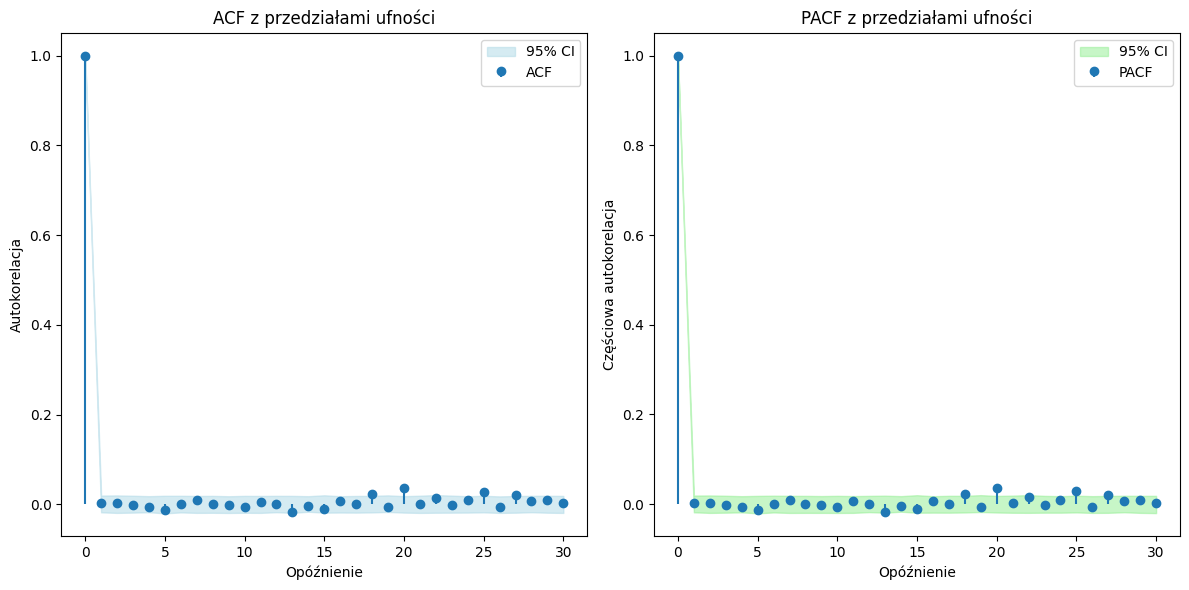

In [ ]:
residuals = model_fit.resid.dropna().values  
n = len(residuals)
m = 1000 
lags = 30 

acf_samples = np.zeros((m, lags + 1))
pacf_samples = np.zeros((m, lags + 1))

for i in range(m):
    boot_resid = np.random.choice(residuals, size=n, replace=True)
    
    acf_samples[i] = acf(boot_resid, nlags=lags, fft=True)
    pacf_samples[i] = pacf(boot_resid, nlags=lags)

acf_confidence = np.percentile(acf_samples, [2.5, 97.5], axis=0)
pacf_confidence = np.percentile(pacf_samples, [2.5, 97.5], axis=0)

acf_vals = acf(residuals, nlags=lags, fft=True)
pacf_vals = pacf(residuals, nlags=lags)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.fill_between(range(lags + 1), acf_confidence[0], acf_confidence[1], color='lightblue', alpha=0.5, label="95% CI")
plt.stem(range(lags + 1), acf_vals, basefmt=" ", label="ACF")  
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF z przedziałami ufności')
plt.legend()

plt.subplot(1, 2, 2)
plt.fill_between(range(lags + 1), pacf_confidence[0], pacf_confidence[1], color='lightgreen', alpha=0.5, label="95% CI")
plt.stem(range(lags + 1), pacf_vals, basefmt=" ", label="PACF") 
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF z przedziałami ufności')
plt.legend()

plt.tight_layout()
plt.show()

## CZĘŚĆ PIĄTA

### Średnia

T-statystyka: 0.05650135245194924, p-wartość: 0.9549434487513435


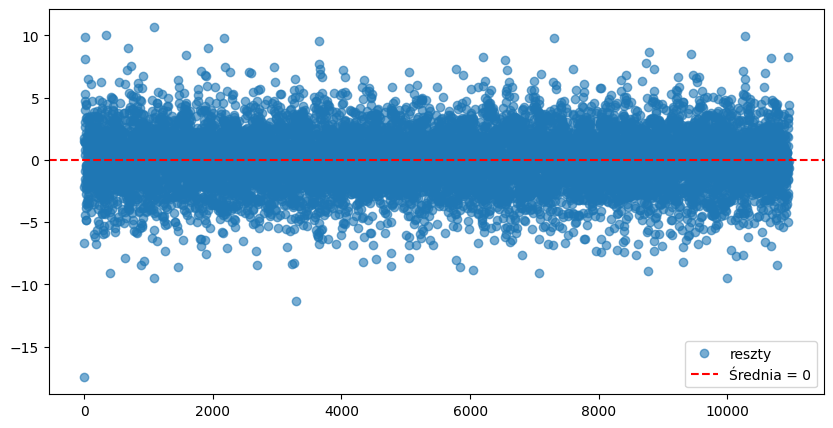

In [17]:
t_stat, p_value = stats.ttest_1samp(residuals, 0)
print(f"T-statystyka: {t_stat}, p-wartość: {p_value}")

plt.figure(figsize=(10, 5))
plt.plot(residuals, label="reszty", marker='o', linestyle='', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label="Średnia = 0")
plt.legend()
plt.show()

### Wariancja reszt

In [18]:
group1 = residuals[:5000]
group2 = residuals[5000:]

stat, p_value = stats.levene(group1, group2)
print(f"Wartość testu Levene'a: {stat}, p-value: {p_value}")


Wartość testu Levene'a: 0.3430657922378633, p-value: 0.5580769805681582


In [19]:
stat, p_value, _, _ = het_arch(residuals)

print(f"Wartość testu ARCH: {stat}, p-value: {p_value}")

Wartość testu ARCH: 163.4050563505887, p-value: 6.416434826714622e-30


In [ ]:
time_index = range(len(residuals))
X_with_const = sm.add_constant(time_index)

gq_test = het_goldfeldquandt(residuals, X_with_const, split=0.5)

labels = ['Statystyka GQ', 'p-value', 'Hipoteza alternatywna']
results = dict(zip(labels, gq_test))

for key, value in results.items():
    print(f"{key}: {value}")

Statystyka GQ: 0.9706780238323138
p-value: 0.8645442316660311
Hipoteza alternatywna: increasing


### Niezależność reszt

<Figure size 1000x500 with 0 Axes>

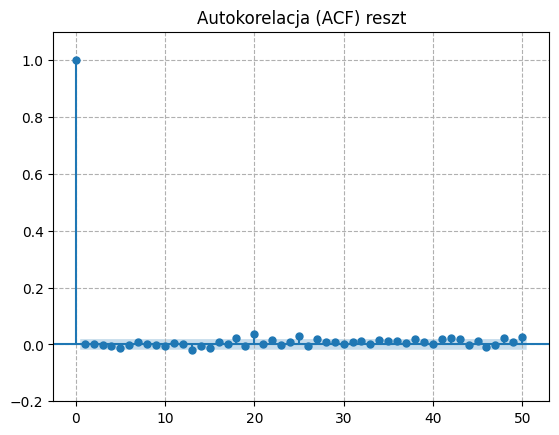

<Figure size 1000x500 with 0 Axes>

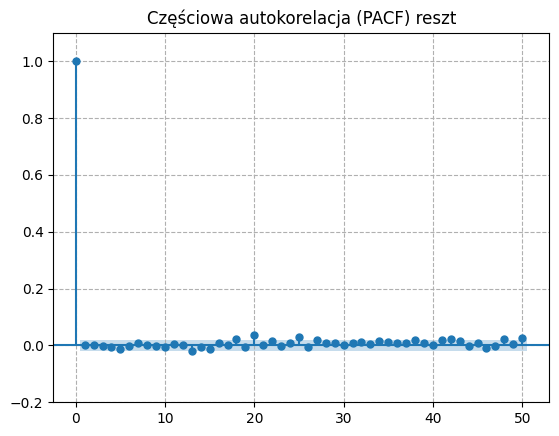

In [22]:
plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=50, alpha=0.05, title="Autokorelacja (ACF) reszt")
plt.ylim(-0.2, 1.1)
plt.grid(linestyle="--")
plt.show()

plt.figure(figsize=(10, 5))
plot_pacf(residuals, lags=50, alpha=0.05, title="Częściowa autokorelacja (PACF) reszt")
plt.ylim(-0.2, 1.1)
plt.grid(linestyle="--")
plt.show()

In [ ]:
print(acorr_ljungbox(residuals, lags=40))

      lb_stat  lb_pvalue
1    0.070504   0.790605
2    0.098422   0.951980
3    0.157684   0.984113
4    0.566194   0.966745
5    2.463182   0.782030
6    2.465335   0.872327
7    3.467550   0.838650
8    3.487998   0.900119
9    3.504749   0.940893
10   3.892169   0.952080
11   4.279211   0.961026
12   4.279774   0.977842
13   7.863613   0.852371
14   8.054989   0.886442
15   9.419019   0.854610
16  10.058720   0.863544
17  10.059306   0.901105
18  15.506498   0.626946
19  16.019499   0.655977
20  30.705842   0.059196
21  30.732495   0.078227
22  33.074906   0.060828
23  33.091498   0.079485
24  34.142393   0.082170
25  42.889395   0.014393
26  43.211275   0.018347
27  47.912740   0.007852
28  48.619127   0.009183
29  49.663840   0.009815
30  49.694547   0.013339
31  50.396647   0.015287
32  52.244446   0.013389
33  52.295577   0.017682
34  55.105644   0.012466
35  56.307703   0.012662
36  57.627009   0.012514
37  57.982256   0.015278
38  62.519008   0.007355
39  63.341361   0.008155


### Normalność rozkładu

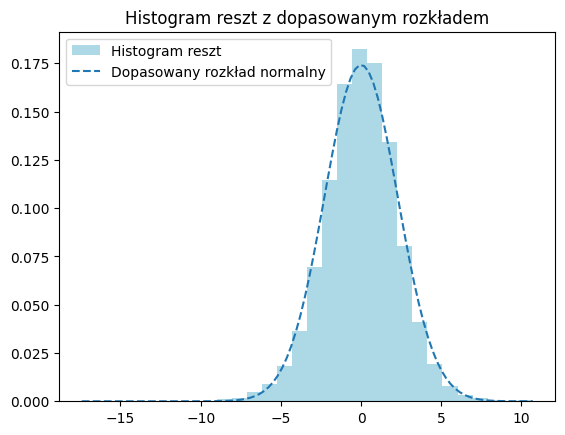

In [24]:
plt.hist(residuals, bins=30, color="lightblue", density=True, label="Histogram reszt")
mean, std = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
pdf = stats.norm.pdf(x, loc=mean, scale=std)
plt.plot(x, pdf, linestyle="--", label="Dopasowany rozkład normalny")
plt.title("Histogram reszt z dopasowanym rozkładem")
plt.legend()
plt.show()

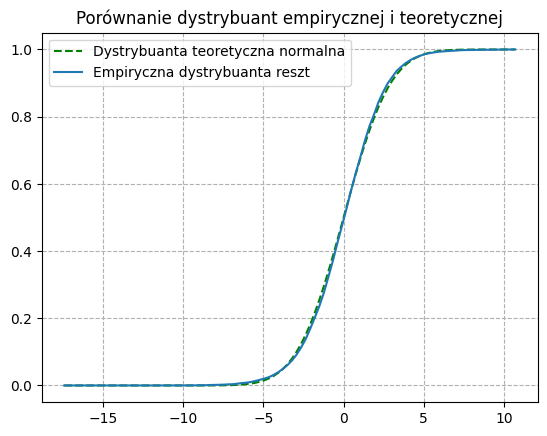

In [25]:
ecdf = ECDF(residuals)
x = np.linspace(residuals.min(), residuals.max(), 100)
cdf_theoretical = stats.norm.cdf(x, loc=mean, scale=std)

plt.plot(x, cdf_theoretical, linestyle="--", color="g", label="Dystrybuanta teoretyczna normalna")
plt.plot(x, ecdf(x), label="Empiryczna dystrybuanta reszt")
plt.title("Porównanie dystrybuant empirycznej i teoretycznej")
plt.legend()
plt.grid(linestyle="--")
plt.show()

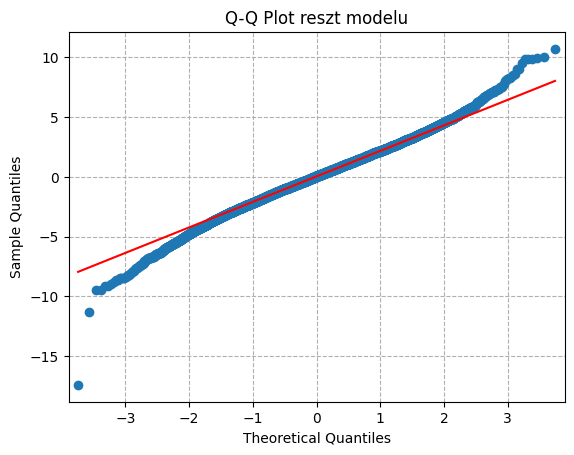

In [26]:
statsmodels.api.qqplot(residuals, line='q')
plt.title("Q-Q Plot reszt modelu")
plt.grid(linestyle="--")
plt.show()

In [27]:
stat_shapiro, p_shapiro = stats.shapiro(residuals)
print(f"Shapiro-Wilk test: Statystyka={stat_shapiro}, P-Wartość={p_shapiro}")

stat_jb, p_jb = stats.jarque_bera(residuals)
print(f"Jarque-Bera test: Statystyka={stat_jb}, P-Wartość={p_jb}")

Shapiro-Wilk test: Statystyka=0.9936943119809636, P-Wartość=1.5407597016054108e-21
Jarque-Bera test: Statystyka=557.4921541091355, P-Wartość=8.752192940195831e-122


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10954.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
params = t.fit(residuals)
ks_test = kstest(residuals, 't', args=params)

print(f"Statystyka testowa: {ks_test.statistic:.4f}")
print(f"p-wartość: {ks_test.pvalue:.4f}")


Statystyka testowa: 0.0078
p-wartość: 0.5092


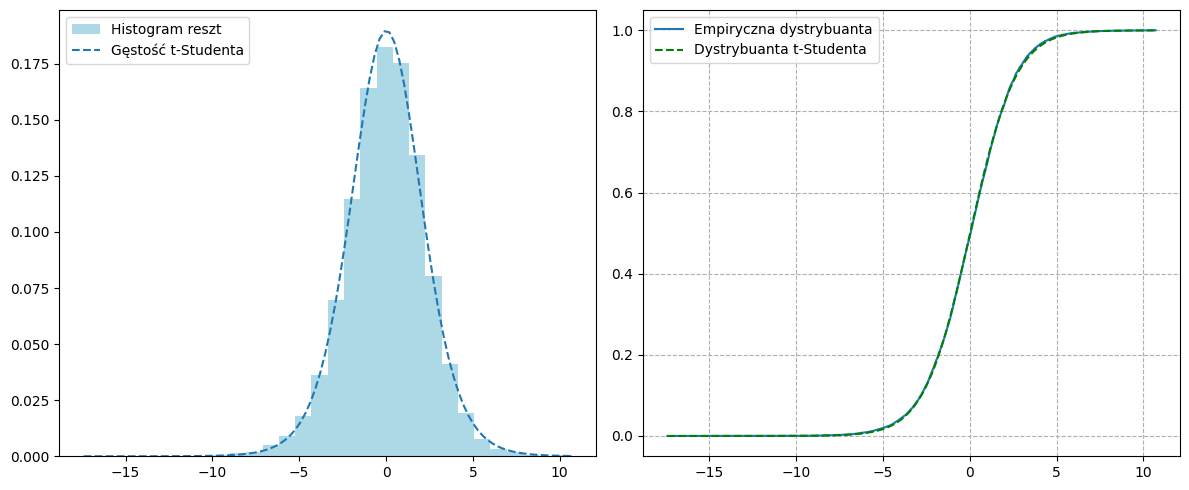

In [ ]:
df, loc, scale = params
x = np.linspace(min(residuals), max(residuals), 100)
pdf_fitted = t.pdf(x, df, loc, scale)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, color="lightblue", density=True, label="Histogram reszt")
plt.plot(x, pdf_fitted, linestyle="--", label="Gęstość t-Studenta")
plt.legend()

plt.subplot(1, 2, 2)
sorted_residuals = np.sort(residuals)
empirical_cdf = np.arange(1, len(sorted_residuals) + 1) / len(sorted_residuals)
fitted_cdf = t.cdf(sorted_residuals, df, loc, scale)

plt.plot(sorted_residuals, empirical_cdf, label='Empiryczna dystrybuanta')
plt.plot(sorted_residuals, fitted_cdf, linestyle="--", color="g", label='Dystrybuanta t-Studenta')
plt.grid(linestyle="--")
plt.legend()

plt.tight_layout()
plt.show()